In [ ]:
from google.colab import drive
import os 

drive.mount('/content/drive')

path = '/content/drive/MyDrive/Hepsiburada Sentiment'

data_path = path + '/' + os.listdir(path)[0]

In [16]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GRU, Dense

from tensorflow.keras import optimizers

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [241]:
data = pd.read_csv(data_path)
data.head() 

df = data.copy()

df.head()

,Rating,Review
0,1,3 yıldır tık demedi. :)
1,1,3 yıldır kullanıyorum müthiş
2,1,Ürün bugün elime geçti çok fazla inceleme fırs...
3,1,Almaya karar verdim. Hemencecik geldi. Keyifle...
4,1,Günlük kullanımınızı çok çok iyi karsılıyor kı...


<Axes: >

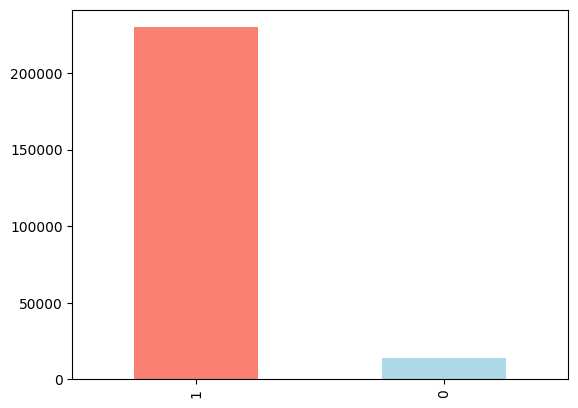

In [195]:
df['Rating'].value_counts().plot(
    kind='bar', color=['salmon', 'lightblue']
)

In [4]:
X = df['Review']
y = df['Rating']

In [5]:
stopwords.words('turkish')[10:20]

['bu', 'çok', 'çünkü', 'da', 'daha', 'de', 'defa', 'diye', 'eğer', 'en']

In [6]:
# Test

sample_text = 'Bugün hava çok güzel, sıcaklık 30 derece. defa'

turkish_stopwords = stopwords.words('turkish')

sample_text = re.compile(r'[^a-zA-ZğüşıöçĞÜŞİÖÇ]').sub(' ', sample_text)
sample_text = ''.join([word.lower() for word  in sample_text])
sample_text = [word for word in sample_text.split() if word not in turkish_stopwords]
sample_text

['bugün', 'hava', 'güzel', 'sıcaklık', 'derece']

In [7]:
def remove_stopwords(text):
    text = re.compile(r'[^a-zA-ZğüşıöçĞÜŞİÖÇ]').sub(' ', text)
    text = ''.join([word.lower() for word in text])
    text = [word for word in text.split() if word not in turkish_stopwords]
    return text

X_wsw = X.apply(remove_stopwords)

In [8]:
normal_x = [len(text) for text in X]
wstp_x = [len(text) for text in X_wsw]

print('normal length:', max(normal_x))
print('without stopwords length:', max(wstp_x))

normal length: 2058
without stopwords length: 262


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X_wsw, y, test_size=0.2, random_state=42
)
X_train.shape, y_train.shape

((194797,), (194797,))

In [10]:
tokenizer = Tokenizer(num_words=10000)

tokenizer.fit_on_texts(X_wsw)

X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)

In [11]:
num_tokens = np.array([len(token) for token in X_train_token + X_test_token])
num_tokens[:10]

array([16, 19, 15,  2, 19,  4,  4, 30, 27, 13])

In [12]:
print('mean', num_tokens.mean())
print('std', num_tokens.std())
print('argmax', num_tokens.argmax())

mean 17.30798736740083
std 16.1024913789149
argmax 234980


In [13]:
max_token = int(num_tokens.mean() + (2 * num_tokens.std()))
max_token

49

In [14]:
X_train_tokenized_pad = pad_sequences(X_train_token, maxlen=max_token)
X_test_tokenized_pad = pad_sequences(X_test_token, maxlen=max_token)
X_train_tokenized_pad.shape

(194797, 49)

In [17]:
model = Sequential()

model.add(Embedding(
    input_dim=10000,
    output_dim=50,
    input_length=49
))

model.add(GRU(units=16, activation='tanh', return_sequences=True))
model.add(GRU(units=8, activation='tanh', return_sequences=True))
model.add(GRU(units=4, activation='tanh', return_sequences=False))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizer.RMSprop(), metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 49, 50)            500000    
                                                                 
 gru_3 (GRU)                 (None, 49, 16)            3264      
                                                                 
 gru_4 (GRU)                 (None, 49, 8)             624       
                                                                 
 gru_5 (GRU)                 (None, 4)                 168       
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 504061 (1.92 MB)
Trainable params: 504061 (1.92 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
model.fit(X_train_tokenized_pad, y_train, epochs=2)

Epoch 1/2
6088/6088 [==============================] - 370s 59ms/step - loss: 0.1364 - accuracy: 0.9552
Epoch 2/2
6088/6088 [==============================] - 371s 61ms/step - loss: 0.1099 - accuracy: 0.9629


In [19]:
model.evaluate(X_test_tokenized_pad, y_test)[1] 

1522/1522 [==============================] - 16s 9ms/step - loss: 0.1088 - accuracy: 0.9650


0.9650102853775024